In [532]:
import pandas as pd

!pip3 install catboost
from IPython.display import clear_output

# предсказывать на основе MAPE для маленьких значений и на основе MAE для больших

clear_output()

In [533]:
# population get

Population_file_path = 'Distance.xlsx'
population = pd.read_excel(Population_file_path, sheet_name='Population_quart')
population = list(population.Population)

number_of_quarts = len(population)

In [534]:
# distance get

Distance_file_path = 'Distance.xlsx'
distance = pd.read_excel(Distance_file_path, sheet_name='Distance_from_quart', index_col='Id')

distance_from_market = {}
ids = []
for Id in distance.columns:
    distance_from_market[Id] = list(distance[Id])
    ids.append(Id)

In [535]:
# market data get

Markets_file_path = 'Market_data_changed21.xlsx' # 21 is best for MAE - 25000epochs, 41 for MAPE - 8000epochs
market_data = pd.read_excel(Markets_file_path, index_col='Full_Address')

Coord_file_path = 'Coord.xlsx'
coord = pd.read_excel(Coord_file_path, index_col='Full_Address')

market_data = market_data.join(coord)

market_data = market_data.reset_index()
market_data.head()

,Full_Address,Type,Square,Categorical_Brand,Traffic,Time,Building_Type,Frequency,Id,lat,lon
0,1 Новосмоленская набережная Санкт-Петербург,магазин,126.0,Другие,4586,51,жилой дом,89.921569,118,30.230887,59.949145
1,100 Средний проспект В.О. Санкт-Петербург,магазин,131.0,Другие,4339,31,жилой дом,139.967742,152,30.241092,59.931648
2,11 ул. Нахимова Санкт-Петербург,супермаркет,295.0,Пятерочка,26854,39,жилой дом,688.564103,138,30.222111,59.941042
3,12В 17-я линия Васильевского острова Санкт-Пет...,супермаркет,253.7,Пятерочка,22610,31,жилой дом,729.354839,120,30.270979,59.934799
4,13/46 16-я Линия Санкт-Петербург,супермаркет,251.0,ВкусВилл,18190,32,жилой дом,568.437500,122,30.271339,59.935196


In [536]:
# square get

square_of_market = []
for row in market_data.iterrows():
    square_of_market.append({'Id': row[1]['Id'], 'Square': row[1]['Square']})

number_of_markets = len(square_of_market)

In [537]:
# Huff gravity model

# i - number of quart, j- number of market
def huff_probability(i, j, lmbd=0.1):
    Id = square_of_market[j]['Id']
    s_t = square_of_market[j]['Square'] / distance_from_market[Id][i] ** lmbd

    sum_s_t = 0

    for market in square_of_market:
        sum_s_t += market['Square'] / distance_from_market[market['Id']][i] ** lmbd

    return s_t / sum_s_t


huff_pred_by_market = []

for j in range(number_of_markets):
    byuers_count = 0
    for i in range(number_of_quarts):
        prob = huff_probability(i, j)
        byuers_count += prob * population[i]
    huff_pred_by_market.append(byuers_count)

In [538]:
# Huff insertion in DataFrame

market_data.insert(0, 'Huff', huff_pred_by_market)
market_data.head()

,Huff,Full_Address,Type,Square,Categorical_Brand,Traffic,Time,Building_Type,Frequency,Id,lat,lon
0,982.338994,1 Новосмоленская набережная Санкт-Петербург,магазин,126.0,Другие,4586,51,жилой дом,89.921569,118,30.230887,59.949145
1,999.594917,100 Средний проспект В.О. Санкт-Петербург,магазин,131.0,Другие,4339,31,жилой дом,139.967742,152,30.241092,59.931648
2,2282.540896,11 ул. Нахимова Санкт-Петербург,супермаркет,295.0,Пятерочка,26854,39,жилой дом,688.564103,138,30.222111,59.941042
3,1904.088952,12В 17-я линия Васильевского острова Санкт-Пет...,супермаркет,253.7,Пятерочка,22610,31,жилой дом,729.354839,120,30.270979,59.934799
4,1885.942383,13/46 16-я Линия Санкт-Петербург,супермаркет,251.0,ВкусВилл,18190,32,жилой дом,568.437500,122,30.271339,59.935196


In [539]:
# Features and Target

X = market_data
y = market_data['Frequency']
X = X.drop(['Frequency'], axis=1)

X = X.drop(['Full_Address'], axis=1)
#X = X.drop(['Square'], axis=1)
#X = X.drop(['Huff'], axis=1)
X = X.drop(['Traffic'], axis=1)
X = X.drop(['Time'], axis=1)
X = X.drop(['Id'], axis=1)
X = X.drop(['lat'], axis=1)
X = X.drop(['lon'], axis=1)
#X = X.drop(['Type'], axis=1)
#X = X.drop(['Categorical_Brand'], axis=1)
#X = X.drop(['Building_Type'], axis=1)


categorical_cols = [col for col in X.columns if X[col].dtype == 'object']
numerical_cols = [cname for cname in X.columns if X[cname].dtype in ['int64', 'float64']]

X.head()

,Huff,Type,Square,Categorical_Brand,Building_Type
0,982.338994,магазин,126.0,Другие,жилой дом
1,999.594917,магазин,131.0,Другие,жилой дом
2,2282.540896,супермаркет,295.0,Пятерочка,жилой дом
3,1904.088952,супермаркет,253.7,Пятерочка,жилой дом
4,1885.942383,супермаркет,251.0,ВкусВилл,жилой дом


In [540]:
# One-hot encoding

X = pd.get_dummies(X, columns=categorical_cols)

epoch 0, loss 230.8536834716797
epoch 5000, loss 54.20088577270508
epoch 10000, loss 55.68436813354492
epoch 15000, loss 48.8546257019043
epoch 20000, loss 44.375022888183594
epoch 25000, loss 37.06462478637695


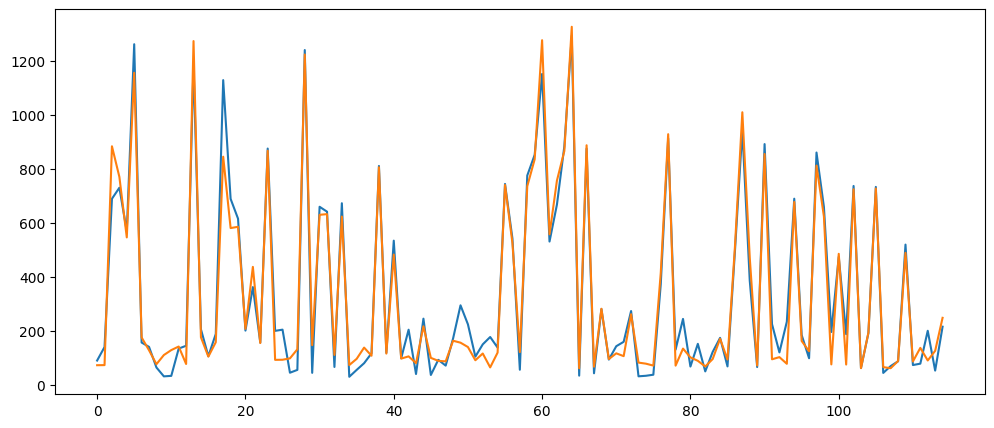

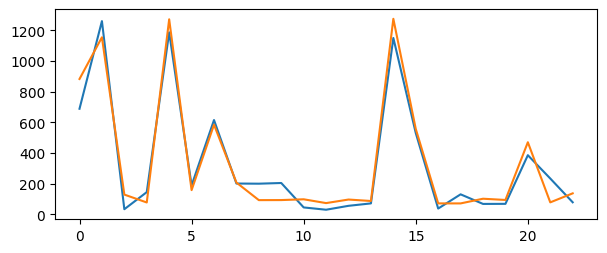

[[688.5640869140625], [1260.4193115234375], [33.27586364746094], [144.62069702148438], [1186.914306640625], [188.36363220214844], [614.9629516601562], [200.76666259765625], [199.77142333984375], [204.2244873046875], [44.86666488647461], [29.85714340209961], [55.375], [71.19999694824219], [1150.4000244140625], [530.28125], [37.5], [130.3125], [67.71428680419922], [68.24137878417969], [385.6071472167969], [233.58621215820312], [78.41935729980469]]
69.08380889892578
all data: 45.685211181640625
epoch 0, loss 383.8824157714844
epoch 5000, loss 58.89059829711914
epoch 10000, loss 45.18256759643555
epoch 15000, loss 44.038063049316406
epoch 20000, loss 38.37493133544922
epoch 25000, loss 46.52962112426758


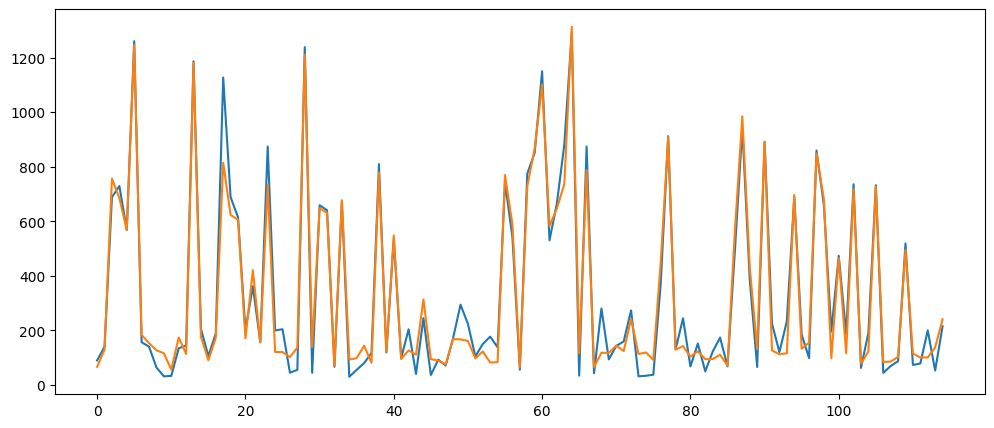

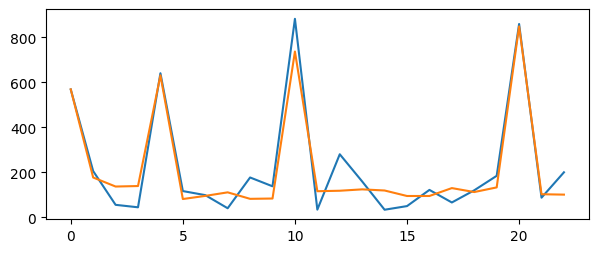

[[568.4375], [205.34483337402344], [55.35483932495117], [44.400001525878906], [640.7930908203125], [116.5686264038086], [98.55172729492188], [40.13333511352539], [177.03225708007812], [137.8275909423828], [882.7096557617188], [34.068965911865234], [280.3235168457031], [159.2413787841797], [33.56666564941406], [49.75862121582031], [121.75862121582031], [65.85713958740234], [120.06896209716797], [184.35484313964844], [859.6666870117188], [87.1875], [200.06666564941406]]
56.700111389160156
all data: 45.45631790161133
epoch 0, loss 283.3979797363281
epoch 5000, loss 66.8585433959961
epoch 10000, loss 45.55124282836914
epoch 15000, loss 41.650333404541016
epoch 20000, loss 38.2550163269043
epoch 25000, loss 46.417198181152344


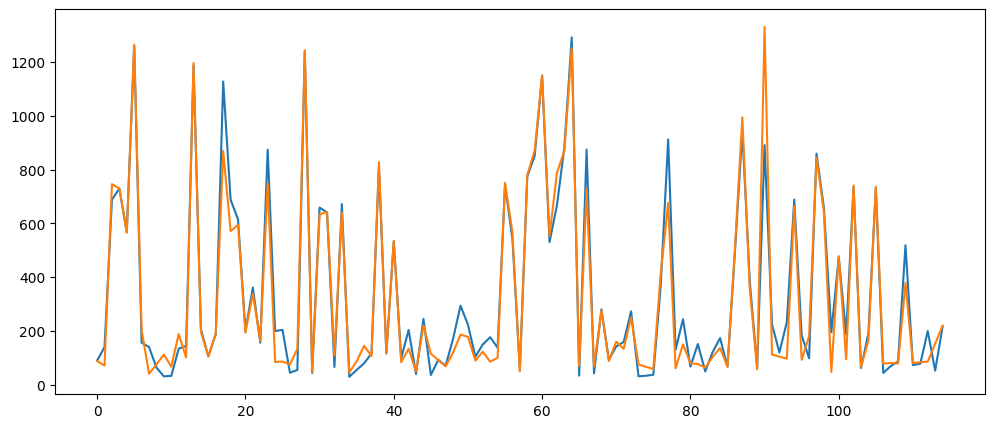

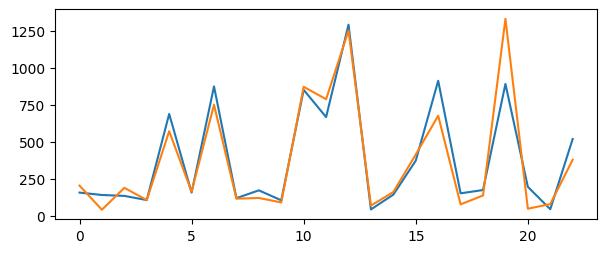

[[156.55555725097656], [140.41378784179688], [134.27586364746094], [106.03448486328125], [688.1613159179688], [156.48484802246094], [874.3103637695312], [118.89655303955078], [171.76666259765625], [104.4000015258789], [851.1666870117188], [666.84375], [1291.72412109375], [42.8125], [142.93548583984375], [372.5], [912.1666870117188], [151.6896514892578], [173.86666870117188], [890.8928833007812], [195.5806427001953], [44.135135650634766], [518.94287109375]]
82.39258575439453
all data: 45.592689514160156
epoch 0, loss 371.2676086425781
epoch 5000, loss 46.733707427978516
epoch 10000, loss 42.90916442871094
epoch 15000, loss 41.6768913269043
epoch 20000, loss 34.29888916015625
epoch 25000, loss 36.58015441894531


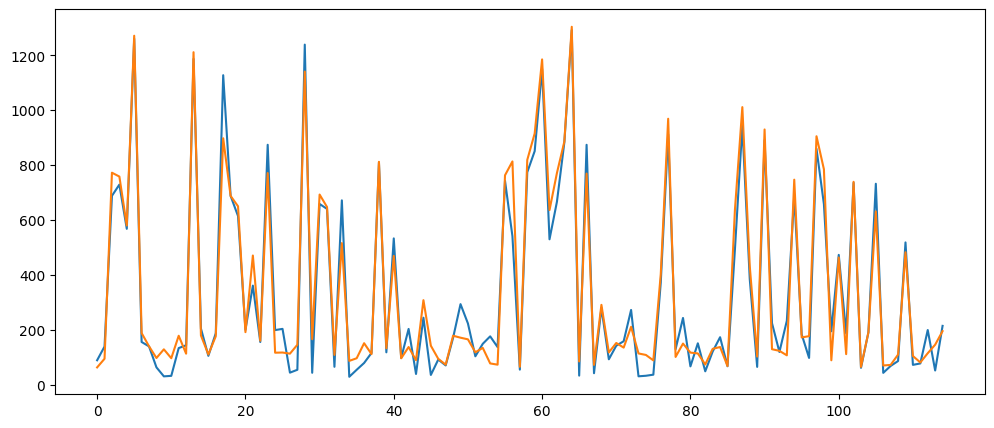

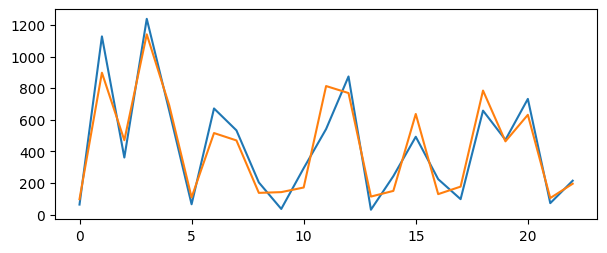

[[64.17241668701172], [1127.5806884765625], [361.6388854980469], [1238.857177734375], [658.933349609375], [66.17241668701172], [672.0322875976562], [533.5428466796875], [204.06666564941406], [36.54838562011719], [294.258056640625], [541.7586059570312], [874.2413940429688], [31.566667556762695], [244.0], [493.0625], [224.8000030517578], [98.4000015258789], [658.25927734375], [473.54840087890625], [732.4483032226562], [73.2258071899414], [215.15625]]
96.61479187011719
all data: 50.93450164794922
epoch 0, loss 353.238525390625
epoch 5000, loss 52.410953521728516
epoch 10000, loss 52.160526275634766
epoch 15000, loss 43.79988479614258
epoch 20000, loss 35.278560638427734
epoch 25000, loss 35.007728576660156


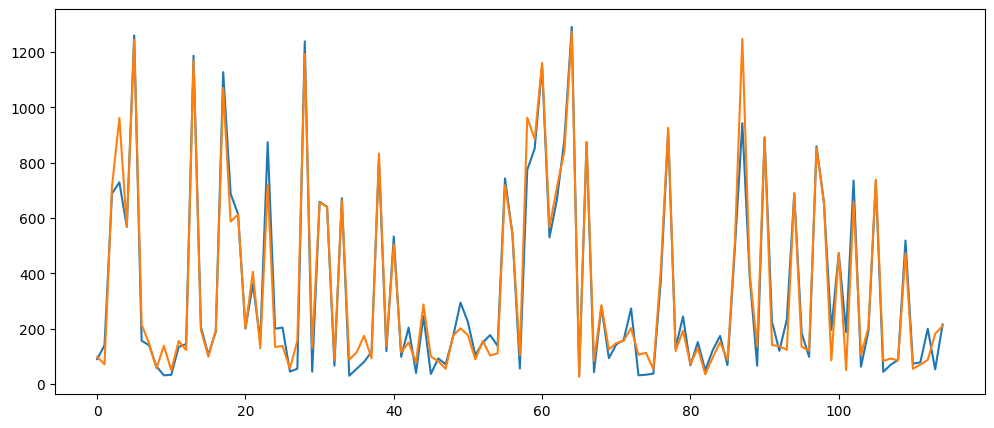

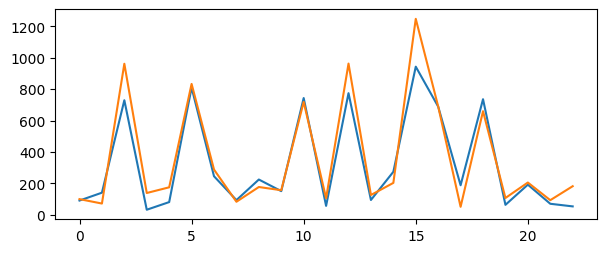

[[89.92156982421875], [139.96774291992188], [729.3548583984375], [31.384614944458008], [80.07843017578125], [809.9354858398438], [244.8709716796875], [92.5999984741211], [223.90908813476562], [149.86666870117188], [743.3793334960938], [55.90625], [774.5], [93.51724243164062], [273.23333740234375], [943.3103637695312], [688.7999877929688], [187.41378784179688], [735.914306640625], [62.53333282470703], [191.1666717529297], [69.36111450195312], [52.66666793823242]]
75.40971374511719
all data: 41.040802001953125
valid data mean: 76.04020233154297
all data mean: 45.74190444946289


In [541]:
from torch.nn import MSELoss, L1Loss
from sklearn.model_selection import KFold
import torch
from torch import nn
from torch.autograd import Variable
from torchmetrics import MeanAbsolutePercentageError

torch.manual_seed(17)


x_data_all = Variable(torch.Tensor(X.values))
y_data_all = Variable(torch.Tensor([[target] for target in y.values]))

class LinearRegressionModel(torch.nn.Module):

    def __init__(self):
        super(LinearRegressionModel, self).__init__()
        self.layers = torch.nn.Sequential(
            torch.nn.Linear(len(x_data_all[0]), 64),
            nn.LeakyReLU(0.1),
            nn.Linear(64, 32),
            nn.LeakyReLU(0.1),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        y_pred = self.layers(x)
        return y_pred




loss = L1Loss()
loss1 = MSELoss()
loss2 = MeanAbsolutePercentageError()



from sklearn.model_selection import KFold

kf = KFold(n_splits=5, random_state=4, shuffle=True)

metrics_valid = []
metrics_all = []

for train_ind, test_ind in kf.split(X):

    x_data_train = Variable(torch.Tensor(X.values[train_ind]))
    y_data_train = Variable(torch.Tensor([[target] for target in y.values[train_ind]]))

    x_data_valid = Variable(torch.Tensor(X.values[test_ind]))
    y_data_valid = Variable(torch.Tensor([[target] for target in y.values[test_ind]]))


    m_model = LinearRegressionModel()

    optimizer_ln = torch.optim.Adam(m_model.parameters(), lr=0.008)

    for epoch in range(25001):

        pred_y = m_model(x_data_train)
        loss_ln = loss(pred_y, y_data_train)

        optimizer_ln.zero_grad()
        loss_ln.backward()
        optimizer_ln.step()
        if epoch % 5000 == 0:
             print('epoch {}, loss {}'.format(epoch, loss_ln.item()))


    m_predictions = m_model(x_data_valid)
    m_predictions_all = m_model(x_data_all)

    loss_valid = loss(m_predictions, y_data_valid)
    loss_all = loss(m_predictions_all, y_data_all)

    import matplotlib.pyplot as plt

    fig1 = plt.figure(figsize=(12, 5))
    fig2 = plt.figure(figsize=(7, 6))

    ax2 = fig1.add_subplot(111)
    ax = fig2.add_subplot(211)

    ax.plot(list(i for i in range(len(y_data_valid.tolist()))), list(y_data_valid.tolist()))
    ax.plot(list(i for i in range(len(y_data_valid.tolist()))), m_predictions.tolist())

    ax2.plot(list(i for i in range(len(y))), list(y))
    ax2.plot(list(i for i in range(len(y))), m_predictions_all.tolist())

    plt.show()
    print(list(y_data_valid.tolist()))
    loss_valid = loss(m_predictions, y_data_valid)
    loss_all = loss(m_predictions_all, y_data_all)

    print(loss_valid.item())
    print('all data:', loss_all.item())

    metrics_valid.append(loss_valid.item())
    metrics_all.append(loss_all.item())



from statistics import mean

print('valid data mean:', mean(metrics_valid))
print('all data mean:', mean(metrics_all))

In [542]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.95, test_size=0.05, random_state=4)


In [543]:
# from sklearn.preprocessing import StandardScaler
# from sklearn.preprocessing import MinMaxScaler
# # MinMaxScaler
#
# pda = MinMaxScaler()
#
# pda.fit(X_train)
#
# X = pda.transform(X)
# X_train = pda.transform(X_train)
# X_valid = pda.transform(X_valid)

In [544]:
# PyTorch model_ln train

# import torch
# from torch import nn
# from torch.autograd import Variable
# from torchmetrics import MeanAbsolutePercentageError
#
# torch.manual_seed(17)
#
# x_data = Variable(torch.Tensor(X_train.values))
# y_data = Variable(torch.Tensor([[target] for target in y_train.values]))
#
#
# class LinearRegressionModel(torch.nn.Module):
#
#     def __init__(self):
#         super(LinearRegressionModel, self).__init__()
#         self.layers = torch.nn.Sequential(
#             torch.nn.Linear(len(x_data[0]), 64),
#             nn.LeakyReLU(0.1),
#             nn.Linear(64, 32),
#             nn.LeakyReLU(0.1),
#             nn.Linear(32, 1)
#         )
#
#     def forward(self, x):
#         y_pred = self.layers(x)
#         return y_pred
#
#
# torch_model_ln = LinearRegressionModel()
#
# loss_fn_ln = MeanAbsolutePercentageError()
#
# from torch.nn import MSELoss
# loss_fn_ln2 = MSELoss()
#
# optimizer_ln = torch.optim.Adam(torch_model_ln.parameters(), lr=0.008)
#
# for epoch in range(25001):
#
#     pred_y = torch_model_ln(x_data)
#     loss_ln = loss_fn_ln(pred_y, y_data)
#
#     optimizer_ln.zero_grad()
#     loss_ln.backward()
#     optimizer_ln.step()
#
#     if epoch % 5000 == 0:
#         print('epoch {}, loss {}'.format(epoch, loss_ln.item()))

In [545]:
# #py_torch model validation
#
# x_data_all = Variable(torch.Tensor(X.values))
# y_data_all = Variable(torch.Tensor([[target] for target in y.values]))
#
#
# x_data_valid = Variable(torch.Tensor(X_valid.values))
# y_data_valid = Variable(torch.Tensor([[target] for target in y_valid.values]))

In [546]:
# import matplotlib.pyplot as plt

In [547]:
# def compare_valid_torch(m_model, loss):
#     m_predictions = m_model(x_data_valid)
#     m_predictions_all = m_model(x_data_all)
#
#     fig1 = plt.figure(figsize=(12, 5))
#     fig2 = plt.figure(figsize=(7, 6))
#
#     ax2 = fig1.add_subplot(111)
#     ax = fig2.add_subplot(211)
#
#     ax.plot(list(i for i in range(len(y_valid))), list(y_valid))
#     ax.plot(list(i for i in range(len(y_valid))), m_predictions.tolist())
#
#     ax2.plot(list(i for i in range(len(y))), list(y))
#     ax2.plot(list(i for i in range(len(y))), m_predictions_all.tolist())
#
#     plt.show()
#
#     loss_valid = loss(m_predictions, y_data_valid)
#     loss_all = loss(m_predictions_all, y_data_all)
#
#     print(loss_valid.item())
#     print('all data:', loss_all.item())

In [548]:
# compare_valid_torch(torch_model_ln, loss_fn_ln)